# XGBoost Recommender with temporal data

In [129]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

customer_info = pd.read_csv('CustomerInfo2.csv')
product_info = pd.read_csv('ProductInfo.csv')
df = pd.merge(customer_info, product_info, on='CustomerID')

# Add NextProductPurchased column
products = ['PersonalLoan', 'HomeLoan', 'VehicleLoan', 'EducationLoan', 'Insurance', 'VehicleInsurance', 'MutualFund', 'FixedDeposit']

In [130]:
df.head()

,CustomerID,Age,Gender,Location,HighestEducation,Income,CreditScore,Profession,DisposableIncome,PersonalLoan_Owned,...,EducationLoan_Amount,Insurance_Owned,Insurance_Amount,VehicleInsurance_Owned,VehicleInsurance_Amount,MutualFund_Owned,MutualFund_Amount,FixedDeposit_Owned,FixedDeposit_Amount,LastProductPurchased
0,1,47,Male,Rural,Graduation,2190000.0,668,Self-employed,569000.0,0,...,0.0,0,0.0,0,0.0,0,0.0,1,149200.0,VehicleLoan
1,2,37,Male,Urban,Masters,4244000.0,689,Business,891000.0,0,...,189000.0,0,0.0,0,0.0,0,0.0,1,230800.0,EducationLoan
2,3,49,Male,Rural,HighSchool,864000.0,635,Salaried,199000.0,0,...,0.0,0,0.0,0,0.0,0,0.0,1,182100.0,VehicleLoan
3,4,62,Male,Rural,Graduation,1545000.0,661,Retired,247000.0,0,...,0.0,0,0.0,1,35500.0,0,0.0,0,0.0,VehicleInsurance
4,5,36,Female,Suburb,HighSchool,1018000.0,711,Salaried,153000.0,0,...,0.0,1,23400.0,0,0.0,0,0.0,0,0.0,Insurance


In [131]:
df.drop(['LastProductPurchased'], axis = 1, inplace=True)

In [132]:
df.head()

,CustomerID,Age,Gender,Location,HighestEducation,Income,CreditScore,Profession,DisposableIncome,PersonalLoan_Owned,...,EducationLoan_Owned,EducationLoan_Amount,Insurance_Owned,Insurance_Amount,VehicleInsurance_Owned,VehicleInsurance_Amount,MutualFund_Owned,MutualFund_Amount,FixedDeposit_Owned,FixedDeposit_Amount
0,1,47,Male,Rural,Graduation,2190000.0,668,Self-employed,569000.0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,1,149200.0
1,2,37,Male,Urban,Masters,4244000.0,689,Business,891000.0,0,...,1,189000.0,0,0.0,0,0.0,0,0.0,1,230800.0
2,3,49,Male,Rural,HighSchool,864000.0,635,Salaried,199000.0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,1,182100.0
3,4,62,Male,Rural,Graduation,1545000.0,661,Retired,247000.0,0,...,0,0.0,0,0.0,1,35500.0,0,0.0,0,0.0
4,5,36,Female,Suburb,HighSchool,1018000.0,711,Salaried,153000.0,0,...,0,0.0,1,23400.0,0,0.0,0,0.0,0,0.0


In [133]:

def get_next_product(row):
    owned_products = [prod for prod in products if row[f'{prod}_Owned'] == 1]
    available_products = list(set(products) - set(owned_products))
    return np.random.choice(available_products) if available_products else None

df['NextProductPurchased'] = df.apply(get_next_product, axis=1)


In [134]:
df.head()

,CustomerID,Age,Gender,Location,HighestEducation,Income,CreditScore,Profession,DisposableIncome,PersonalLoan_Owned,...,EducationLoan_Amount,Insurance_Owned,Insurance_Amount,VehicleInsurance_Owned,VehicleInsurance_Amount,MutualFund_Owned,MutualFund_Amount,FixedDeposit_Owned,FixedDeposit_Amount,NextProductPurchased
0,1,47,Male,Rural,Graduation,2190000.0,668,Self-employed,569000.0,0,...,0.0,0,0.0,0,0.0,0,0.0,1,149200.0,EducationLoan
1,2,37,Male,Urban,Masters,4244000.0,689,Business,891000.0,0,...,189000.0,0,0.0,0,0.0,0,0.0,1,230800.0,Insurance
2,3,49,Male,Rural,HighSchool,864000.0,635,Salaried,199000.0,0,...,0.0,0,0.0,0,0.0,0,0.0,1,182100.0,EducationLoan
3,4,62,Male,Rural,Graduation,1545000.0,661,Retired,247000.0,0,...,0.0,0,0.0,1,35500.0,0,0.0,0,0.0,HomeLoan
4,5,36,Female,Suburb,HighSchool,1018000.0,711,Salaried,153000.0,0,...,0.0,1,23400.0,0,0.0,0,0.0,0,0.0,FixedDeposit


In [135]:
# Add temporal variable for order of product purchase
def get_purchase_dates(row):
    owned_products = [prod for prod in products if row[f'{prod}_Owned'] == 1]
    num_products = len(owned_products)
    
    end_date = datetime.now()
    start_date = end_date - timedelta(days=730)  # 2 years ago
    
    # Generate random dates within the 2-year period
    random_dates = [start_date + timedelta(days=np.random.randint(0, 730)) for _ in range(num_products)]
    
    # Sort dates to maintain a chronological order
    random_dates.sort()
    
    return dict(zip(owned_products, random_dates))

In [136]:
# Apply the function to create the PurchaseDates column
df['PurchaseDates'] = df.apply(get_purchase_dates, axis=1)


In [137]:
df.head()

,CustomerID,Age,Gender,Location,HighestEducation,Income,CreditScore,Profession,DisposableIncome,PersonalLoan_Owned,...,Insurance_Owned,Insurance_Amount,VehicleInsurance_Owned,VehicleInsurance_Amount,MutualFund_Owned,MutualFund_Amount,FixedDeposit_Owned,FixedDeposit_Amount,NextProductPurchased,PurchaseDates
0,1,47,Male,Rural,Graduation,2190000.0,668,Self-employed,569000.0,0,...,0,0.0,0,0.0,0,0.0,1,149200.0,EducationLoan,"{'VehicleLoan': 2024-02-01 16:54:42.596542, 'F..."
1,2,37,Male,Urban,Masters,4244000.0,689,Business,891000.0,0,...,0,0.0,0,0.0,0,0.0,1,230800.0,Insurance,"{'EducationLoan': 2022-09-26 16:54:42.596586, ..."
2,3,49,Male,Rural,HighSchool,864000.0,635,Salaried,199000.0,0,...,0,0.0,0,0.0,0,0.0,1,182100.0,EducationLoan,"{'VehicleLoan': 2023-02-06 16:54:42.596605, 'F..."
3,4,62,Male,Rural,Graduation,1545000.0,661,Retired,247000.0,0,...,0,0.0,1,35500.0,0,0.0,0,0.0,HomeLoan,"{'VehicleLoan': 2022-08-20 16:54:42.596622, 'V..."
4,5,36,Female,Suburb,HighSchool,1018000.0,711,Salaried,153000.0,0,...,1,23400.0,0,0.0,0,0.0,0,0.0,FixedDeposit,{'Insurance': 2023-08-23 16:54:42.596638}


In [138]:
# Expand PurchaseDates into separate columns
for product in products:
    df[f'{product}_PurchaseDate'] = df['PurchaseDates'].apply(lambda x: x.get(product, pd.NaT))

# Drop the temporary PurchaseDates column
df = df.drop('PurchaseDates', axis=1)

In [139]:
df.head()

,CustomerID,Age,Gender,Location,HighestEducation,Income,CreditScore,Profession,DisposableIncome,PersonalLoan_Owned,...,FixedDeposit_Amount,NextProductPurchased,PersonalLoan_PurchaseDate,HomeLoan_PurchaseDate,VehicleLoan_PurchaseDate,EducationLoan_PurchaseDate,Insurance_PurchaseDate,VehicleInsurance_PurchaseDate,MutualFund_PurchaseDate,FixedDeposit_PurchaseDate
0,1,47,Male,Rural,Graduation,2190000.0,668,Self-employed,569000.0,0,...,149200.0,EducationLoan,NaT,NaT,2024-02-01 16:54:42.596542,NaT,NaT,NaT,NaT,2024-04-24 16:54:42.596542
1,2,37,Male,Urban,Masters,4244000.0,689,Business,891000.0,0,...,230800.0,Insurance,NaT,NaT,NaT,2022-09-26 16:54:42.596586,NaT,NaT,NaT,2024-01-09 16:54:42.596586
2,3,49,Male,Rural,HighSchool,864000.0,635,Salaried,199000.0,0,...,182100.0,EducationLoan,NaT,NaT,2023-02-06 16:54:42.596605,NaT,NaT,NaT,NaT,2023-03-22 16:54:42.596605
3,4,62,Male,Rural,Graduation,1545000.0,661,Retired,247000.0,0,...,0.0,HomeLoan,NaT,NaT,2022-08-20 16:54:42.596622,NaT,NaT,2024-03-24 16:54:42.596622,NaT,NaT
4,5,36,Female,Suburb,HighSchool,1018000.0,711,Salaried,153000.0,0,...,0.0,FixedDeposit,NaT,NaT,NaT,NaT,2023-08-23 16:54:42.596638,NaT,NaT,NaT


In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Function to calculate days since purchase
def days_since_purchase(purchase_date):
    if pd.isnull(purchase_date):
        return -1  # not purchased
    return (datetime.now() - purchase_date).days

In [88]:
# Select features and target
features = [col for col in df.columns if col not in ['CustomerID', 'NextProductPurchased']]
X = df[features].copy()

In [89]:
# Transform date columns
date_columns = [col for col in X.columns if col.endswith('_PurchaseDate')]
for col in date_columns:
    X[f'{col}_DaysSince'] = X[col].apply(days_since_purchase)
    X = X.drop(col, axis=1)

In [90]:
X.head()

,Age,Gender,Location,HighestEducation,Income,CreditScore,Profession,DisposableIncome,PersonalLoan_Owned,PersonalLoan_Amount,...,FixedDeposit_Owned,FixedDeposit_Amount,PersonalLoan_PurchaseDate_DaysSince,HomeLoan_PurchaseDate_DaysSince,VehicleLoan_PurchaseDate_DaysSince,EducationLoan_PurchaseDate_DaysSince,Insurance_PurchaseDate_DaysSince,VehicleInsurance_PurchaseDate_DaysSince,MutualFund_PurchaseDate_DaysSince,FixedDeposit_PurchaseDate_DaysSince
0,47,Male,Rural,Graduation,2190000.0,668,Self-employed,569000.0,0,0.0,...,1,149200.0,-1,-1,722,-1,-1,-1,-1,504
1,37,Male,Urban,Masters,4244000.0,689,Business,891000.0,0,0.0,...,1,230800.0,-1,-1,-1,580,-1,-1,-1,51
2,49,Male,Rural,HighSchool,864000.0,635,Salaried,199000.0,0,0.0,...,1,182100.0,-1,-1,331,-1,-1,-1,-1,149
3,62,Male,Rural,Graduation,1545000.0,661,Retired,247000.0,0,0.0,...,0,0.0,-1,-1,272,-1,-1,108,-1,-1
4,36,Female,Suburb,HighSchool,1018000.0,711,Salaried,153000.0,0,0.0,...,0,0.0,-1,-1,-1,-1,396,-1,-1,-1


In [91]:
# Encode categorical variables
cat_cols = ['Gender', 'Location', 'HighestEducation', 'Profession']
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

In [92]:
X.head()

,Age,Gender,Location,HighestEducation,Income,CreditScore,Profession,DisposableIncome,PersonalLoan_Owned,PersonalLoan_Amount,...,FixedDeposit_Owned,FixedDeposit_Amount,PersonalLoan_PurchaseDate_DaysSince,HomeLoan_PurchaseDate_DaysSince,VehicleLoan_PurchaseDate_DaysSince,EducationLoan_PurchaseDate_DaysSince,Insurance_PurchaseDate_DaysSince,VehicleInsurance_PurchaseDate_DaysSince,MutualFund_PurchaseDate_DaysSince,FixedDeposit_PurchaseDate_DaysSince
0,47,1,0,0,2190000.0,668,3,569000.0,0,0.0,...,1,149200.0,-1,-1,722,-1,-1,-1,-1,504
1,37,1,2,2,4244000.0,689,0,891000.0,0,0.0,...,1,230800.0,-1,-1,-1,580,-1,-1,-1,51
2,49,1,0,1,864000.0,635,2,199000.0,0,0.0,...,1,182100.0,-1,-1,331,-1,-1,-1,-1,149
3,62,1,0,0,1545000.0,661,1,247000.0,0,0.0,...,0,0.0,-1,-1,272,-1,-1,108,-1,-1
4,36,0,1,1,1018000.0,711,2,153000.0,0,0.0,...,0,0.0,-1,-1,-1,-1,396,-1,-1,-1


In [93]:
# Create new features
X['TotalLoanAmount'] = X['PersonalLoan_Amount'] + X['HomeLoan_Amount'] + X['VehicleLoan_Amount'] + X['EducationLoan_Amount']
X['TotalInsuranceAmount'] = X['Insurance_Amount'] + X['VehicleInsurance_Amount']
X['TotalInvestmentAmount'] = X['MutualFund_Amount'] + X['FixedDeposit_Amount']

In [94]:
X.head()

,Age,Gender,Location,HighestEducation,Income,CreditScore,Profession,DisposableIncome,PersonalLoan_Owned,PersonalLoan_Amount,...,HomeLoan_PurchaseDate_DaysSince,VehicleLoan_PurchaseDate_DaysSince,EducationLoan_PurchaseDate_DaysSince,Insurance_PurchaseDate_DaysSince,VehicleInsurance_PurchaseDate_DaysSince,MutualFund_PurchaseDate_DaysSince,FixedDeposit_PurchaseDate_DaysSince,TotalLoanAmount,TotalInsuranceAmount,TotalInvestmentAmount
0,47,1,0,0,2190000.0,668,3,569000.0,0,0.0,...,-1,722,-1,-1,-1,-1,504,129300.0,0.0,149200.0
1,37,1,2,2,4244000.0,689,0,891000.0,0,0.0,...,-1,-1,580,-1,-1,-1,51,189000.0,0.0,230800.0
2,49,1,0,1,864000.0,635,2,199000.0,0,0.0,...,-1,331,-1,-1,-1,-1,149,1676000.0,0.0,182100.0
3,62,1,0,0,1545000.0,661,1,247000.0,0,0.0,...,-1,272,-1,-1,108,-1,-1,332000.0,35500.0,0.0
4,36,0,1,1,1018000.0,711,2,153000.0,0,0.0,...,-1,-1,-1,396,-1,-1,-1,0.0,23400.0,0.0


In [149]:
X.corr()

,Age,Gender,Location,HighestEducation,Income,CreditScore,Profession,DisposableIncome,PersonalLoan_Owned,PersonalLoan_Amount,...,HomeLoan_PurchaseDate_DaysSince,VehicleLoan_PurchaseDate_DaysSince,EducationLoan_PurchaseDate_DaysSince,Insurance_PurchaseDate_DaysSince,VehicleInsurance_PurchaseDate_DaysSince,MutualFund_PurchaseDate_DaysSince,FixedDeposit_PurchaseDate_DaysSince,TotalLoanAmount,TotalInsuranceAmount,TotalInvestmentAmount
Age,1.000000,-0.003921,0.000706,0.095736,0.274651,0.004461,-0.114113,0.211508,0.014097,0.013182,...,0.002636,-0.007037,-0.005593,-0.003023,0.004817,0.001260,0.013650,0.013988,0.007988,0.003941
Gender,-0.003921,1.000000,0.014312,-0.002249,-0.000382,-0.012299,0.005887,0.002315,-0.042575,-0.042136,...,0.000947,0.006056,0.020467,-0.009191,0.001938,0.009962,0.010835,-0.009338,-0.009404,0.000188
Location,0.000706,0.014312,1.000000,-0.001472,0.008546,0.010295,-0.019541,-0.002941,-0.002547,-0.001271,...,-0.012475,-0.005243,-0.005937,0.003706,-0.004327,-0.001609,-0.005166,-0.018163,0.001649,-0.004378
HighestEducation,0.095736,-0.002249,-0.001472,1.000000,0.362452,-0.011867,-0.009054,0.285085,0.000955,0.005228,...,0.020820,-0.016699,0.002527,-0.010645,0.008607,0.010168,0.002050,0.001998,-0.001979,-0.006819
Income,0.274651,-0.000382,0.008546,0.362452,1.000000,-0.010548,-0.020691,0.747256,-0.004366,0.011471,...,0.021347,-0.007337,-0.007119,0.006210,-0.006084,0.009743,0.000889,0.012912,-0.006040,0.002275
CreditScore,0.004461,-0.012299,0.010295,-0.011867,-0.010548,1.000000,-0.015849,-0.003080,-0.003334,-0.010529,...,-0.002785,-0.009108,0.019820,-0.013178,0.009057,0.002051,0.005879,-0.009304,-0.000369,0.005584
Profession,-0.114113,0.005887,-0.019541,-0.009054,-0.020691,-0.015849,1.000000,-0.028592,-0.017387,-0.014170,...,0.001064,-0.001066,0.015584,-0.003525,0.002084,0.011475,0.000011,-0.002980,0.005513,-0.002204
DisposableIncome,0.211508,0.002315,-0.002941,0.285085,0.747256,-0.003080,-0.028592,1.000000,-0.012656,-0.001054,...,0.007508,0.007601,-0.001774,-0.006795,-0.000444,0.004194,-0.009198,0.000636,-0.002242,0.000181
PersonalLoan_Owned,0.014097,-0.042575,-0.002547,0.000955,-0.004366,-0.003334,-0.017387,-0.012656,1.000000,0.848503,...,-0.140469,-0.131628,-0.127919,-0.115728,-0.105979,-0.111700,-0.091133,0.021530,-0.113907,-0.095515
PersonalLoan_Amount,0.013182,-0.042136,-0.001271,0.005228,0.011471,-0.010529,-0.014170,-0.001054,0.848503,1.000000,...,-0.117276,-0.105621,-0.112516,-0.096308,-0.090921,-0.089691,-0.078336,0.059025,-0.093207,-0.083628


In [95]:

y = df['NextProductPurchased']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model = XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    eval_metric='mlogloss',
    use_label_encoder = False,
    verbosity =1
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose = True)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

[0]	validation_0-mlogloss:2.05459	validation_1-mlogloss:2.06166
[1]	validation_0-mlogloss:2.03186	validation_1-mlogloss:2.04568
[2]	validation_0-mlogloss:2.01079	validation_1-mlogloss:2.03077
[3]	validation_0-mlogloss:1.99139	validation_1-mlogloss:2.01692
[4]	validation_0-mlogloss:1.97371	validation_1-mlogloss:2.00408
[5]	validation_0-mlogloss:1.95636	validation_1-mlogloss:1.99271
[6]	validation_0-mlogloss:1.94088	validation_1-mlogloss:1.98248
[7]	validation_0-mlogloss:1.92568	validation_1-mlogloss:1.97218
[8]	validation_0-mlogloss:1.91162	validation_1-mlogloss:1.96242
[9]	validation_0-mlogloss:1.89897	validation_1-mlogloss:1.95387
[10]	validation_0-mlogloss:1.88666	validation_1-mlogloss:1.94592
[11]	validation_0-mlogloss:1.87510	validation_1-mlogloss:1.93865
[12]	validation_0-mlogloss:1.86378	validation_1-mlogloss:1.93152
[13]	validation_0-mlogloss:1.85387	validation_1-mlogloss:1.92510
[14]	validation_0-mlogloss:1.84356	validation_1-mlogloss:1.91882
[15]	validation_0-mlogloss:1.83418	

/opt/anaconda3/envs/recsys/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:05:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-mlogloss:1.79330	validation_1-mlogloss:1.88881
[21]	validation_0-mlogloss:1.78606	validation_1-mlogloss:1.88474
[22]	validation_0-mlogloss:1.77912	validation_1-mlogloss:1.88088
[23]	validation_0-mlogloss:1.77235	validation_1-mlogloss:1.87769
[24]	validation_0-mlogloss:1.76611	validation_1-mlogloss:1.87462
[25]	validation_0-mlogloss:1.76029	validation_1-mlogloss:1.87186
[26]	validation_0-mlogloss:1.75440	validation_1-mlogloss:1.86892
[27]	validation_0-mlogloss:1.74906	validation_1-mlogloss:1.86620
[28]	validation_0-mlogloss:1.74383	validation_1-mlogloss:1.86371
[29]	validation_0-mlogloss:1.73876	validation_1-mlogloss:1.86146
[30]	validation_0-mlogloss:1.73349	validation_1-mlogloss:1.85899
[31]	validation_0-mlogloss:1.72857	validation_1-mlogloss:1.85688
[32]	validation_0-mlogloss:1.72401	validation_1-mlogloss:1.85522
[33]	validation_0-mlogloss:1.71955	validation_1-mlogloss:1.85329
[34]	validation_0-mlogloss:1.71519	validation_1-mlogloss:1.85178
[35]	validation_0-mloglos

In [101]:
X.columns

Index(['Age', 'Gender', 'Location', 'HighestEducation', 'Income',
       'CreditScore', 'Profession', 'DisposableIncome', 'PersonalLoan_Owned',
       'PersonalLoan_Amount', 'HomeLoan_Owned', 'HomeLoan_Amount',
       'VehicleLoan_Owned', 'VehicleLoan_Amount', 'EducationLoan_Owned',
       'EducationLoan_Amount', 'Insurance_Owned', 'Insurance_Amount',
       'VehicleInsurance_Owned', 'VehicleInsurance_Amount', 'MutualFund_Owned',
       'MutualFund_Amount', 'FixedDeposit_Owned', 'FixedDeposit_Amount',
       'PersonalLoan_PurchaseDate_DaysSince',
       'HomeLoan_PurchaseDate_DaysSince', 'VehicleLoan_PurchaseDate_DaysSince',
       'EducationLoan_PurchaseDate_DaysSince',
       'Insurance_PurchaseDate_DaysSince',
       'VehicleInsurance_PurchaseDate_DaysSince',
       'MutualFund_PurchaseDate_DaysSince',
       'FixedDeposit_PurchaseDate_DaysSince', 'TotalLoanAmount',
       'TotalInsuranceAmount', 'TotalInvestmentAmount'],
      dtype='object')

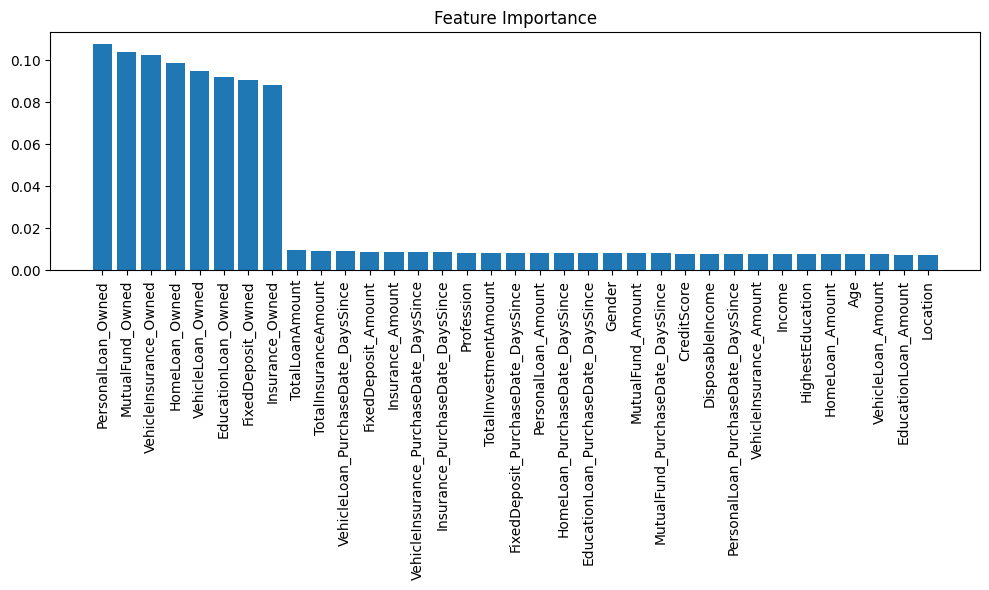

Top 10 Most Important Features:
                                    feature  importance
8                        PersonalLoan_Owned    0.107945
20                         MutualFund_Owned    0.104107
18                   VehicleInsurance_Owned    0.102649
10                           HomeLoan_Owned    0.098565
12                        VehicleLoan_Owned    0.095032
14                      EducationLoan_Owned    0.091975
22                       FixedDeposit_Owned    0.090649
16                          Insurance_Owned    0.088466
32                          TotalLoanAmount    0.009600
33                     TotalInsuranceAmount    0.009083
26       VehicleLoan_PurchaseDate_DaysSince    0.009039
23                      FixedDeposit_Amount    0.008933
17                         Insurance_Amount    0.008653
29  VehicleInsurance_PurchaseDate_DaysSince    0.008621
28         Insurance_PurchaseDate_DaysSince    0.008522
6                                Profession    0.008346
34              

In [104]:
import matplotlib.pyplot as plt

# Get feature importance
importance = model.feature_importances_
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(20))

In [102]:
# import shap

# # Explain the model's predictions using SHAP
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)

# # Visualize the first prediction's explanation
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

# # Summary plot
# shap.summary_plot(shap_values, X_test)

ImportError: cannot import name 'threadpool_info' from 'sklearn.utils.fixes' (/opt/anaconda3/envs/recsys/lib/python3.11/site-packages/sklearn/utils/fixes.py)